In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [1]:
import PySimpleGUI as sg    
from pykat import finesse
from pykat.commands import * 
import pykat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import math
import datetime
# LightGrey2ボタンの背景が見えない
# チェックボックスが見えないからどのテーマでも個別に設定するべき
sg.theme('LightGrey2')

def collapse(layout, key):
    """
    Helper function that creates a Column that can be later made hidden, thus appearing "collapsed"
    :param layout: The layout for the section
    :param key: Key used to make this seciton visible / invisible
    :return: A pinned column that can be placed directly into your layout
    :rtype: sg.pin
    """
    return sg.pin(sg.Column(layout, key=key))

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# やること

# 起動した時に自動的に必要なパッケージがインストールされて使えるようになる機能
# 保存されるときの名前が勝手に固有の名前が生成されるようにする -> 今は末尾の.txtとかが表示されない
# 保存した場所がどこかポップアップで表示 
# 画像の保存のチェックボックス -> 要らない気がする
# overplotした時とI,Qの色の分け方を共通にする　IとQの色の分け方をoverplotした時にも同じ色になるようにする　今は全部青色で表示される
# outを別々の変数に格納して比較できるようにとかする -> katファイルの出力だけでいいかどうか

#
# ここチェックする
#BS scan
#(koyama) original vergion log kokeyamasan uses xaxis*
#select xaxis plotscale "log" cause an error with xaxis*
#m ITMX 0.996 0.004 0 nx1 nx2 
#since the config are above, I think it doesnt cause any problem about the correctness of the result
# 
# finesseの結果が正しいかみてみる # 特にMIのtf_dmod2のphaseが全部0だけどあってるか確認する


In [3]:
# やったこと

# pd0の設定までやらないとplotできないようにする
# よく使うポートを全部選択する機能
# ひとまずPRFPMIのタブを作成したが、動作するようなのでDRFPMIなどのタブも作成する
# PRFPMIのタブのDOFがまだできていないので作成する
# DRFPMIのタブをまだ作成していないので、GUIのタブでMIやDRFPMIを選択するとクラッシュするので注意
# ミラーのロスを設定できるようにする
# katファイルを出力する時に作成した日時を挿入する
# PRFPMIでもkatファイルとoutputをtxtで出力できるか確認する
# outputの結果をtxtで出力する、pd1とpd2のところがまだできていない
# legendのサイズが自動的に変えられるようにする 実装しなくて良い
# 図を拡大したりするボタン
# finesseの結果をmatplotlibでplotするところ、複雑になっているので前のバージョンに戻す
# event == FPMI のところ関数にしたら全部のタブで共通にできそう
# l_ いらない
# katファイルを作成した時刻をkatファイルに書き込む dt_now
# demod_1 を選んでからtransferfunctionを選び、もう一度sweepを選んだ時demod_1が選択されているが、追加のオプションのセクションが開いていない
# GUIのところ引数にリストで渡したウィンドウだけ表示するようにする
# 選択したpdのリストは表示するところで再利用する 終わった
# 選択したpdをリストで渡して選択した物だけがkatファイルに書き込まれるようにする
# windowを表示/非表示にする部分を関数にした
# pdを選んだ時に何も選ばれていない時エラーが出るはずなので直す
# どのタブでも対応できるようにしたつもりだけど、タブを切り替えてもvalues["kPRFPMI_..."]みたいなやつが残るからこのやり方だとダメかもしれない
# make_katpdのphaseのところFPMIにしか対応していないのでこれを直す
# make_katpdのところ複数タブに対応していない

In [4]:
def generate_kat(pds_for_kat, dic_advanced_setting, selected_interferometer):
    
    # 関数名　　　　　：generate_kat
    # 内容　　　　　　：GUIで選択した設定のfinesseのkatテキストを作成する
    # 引数　　　　　　：pds_for_kat, dic_advanced_setting, selected_interferometer
    # 返値　　　　　　：code
    # 使っている変数　：
    
    ##############################
    ### get variables from GUI ###
    ##############################
    
    dof               = dic_advanced_setting["dof"]# pick up DoF (CARM / DARM / BS) from GUI
    type_of_pd_signal = dic_advanced_setting["type_of_pd_signal"]# sw_power/sw_dmod1/tf_power/tf_dmod2
    
    ### xaxis/yaxis setting ###
    x_plotscale       = dic_advanced_setting["x_plotscale"]# linear or log
    xaxis_range_beg   = dic_advanced_setting["xaxis_range_beg"]#plotしたときのx軸の最小値
    xaxis_range_end   = dic_advanced_setting["xaxis_range_end"]#plotしたときのx軸の最大値
    y_plotscale       = dic_advanced_setting["y_plotscale"]#str 

    if x_plotscale=='linear':
        x_plotscale = 'lin'
    if y_plotscale=='linear':
        y_plotscale = 'lin'

    samplingnum       = dic_advanced_setting["samplingnum"]# サンプリング数
    
    ######################
    ### INF components ###
    ######################

    
    # 関数名　　　　　：create_input_finesse
    # 内容　　　　　　：選択した干渉計をfinesseで構成するkatテキストを、GUIのOPTIONタブで設定した例外的な設定を加えて作成する
    # 引数　　　　　　：dic_advanced_setting, selected_interferometer
    # 返値　　　　　　：input_finesse
    # 使っている変数　：
    input_finesse = create_input_finesse(dic_advanced_setting, selected_interferometer)

    ## pds ##
    input_finesse += """
## PDs ##
"""
    for pd in pds_for_kat:
        input_finesse += """%s""" % pd

    ### DoF ###

    ### sweep ###
    if(type_of_pd_signal=="sw_power" or type_of_pd_signal=="sw_dmod1"):
        if(dof=="DARM"):
            input_finesse += """
            
# DARM scan
xaxis ETMX phi %s %s %s %s
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)

        elif(dof=="CARM"):
            input_finesse += """
            
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi %s %s %s %s
put* ETMY phi $x1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)

        elif(dof=="BS" and selected_interferometer!="MI"):
            input_finesse += """
            
# BS scan
#
#(koyama) original vergion log kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi %s %s %s %s
put* ITMY phi $mx1
put* ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
        elif(dof=="BS" and selected_interferometer=="MI"):
            input_finesse += """
            
# BS scan
#
#(koyama) original vergion log kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi %s %s %s %s
put* ITMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
        elif(dof=="PRCL"):
            input_finesse += """
            
# PRM scan
xaxis PRM phi %s %s %s %s
yaxis lin abs
            """% (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
        elif(dof=="SRCL"):
            input_finesse += """
            
# SRM scan
xaxis SRM phi %s %s %s %s
yaxis lin abs
            """% (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
        else:
            pass

    ### transfer function ###
    if(type_of_pd_signal=="tf_power" or type_of_pd_signal=="tf_dmod2"):   
        
        if(dof=="DARM"):
            input_finesse += """
            
### DARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
        elif(dof=="CARM"):
            input_finesse += """
            
### CARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
        elif(dof=="BS"and selected_interferometer!="MI"):
            input_finesse += """
            
### BS ###
fsig sig1 ETMX 10 0
fsig sig1 ITMX 10 0
fsig sig1 ETMY 10 180
fsig sig1 ITMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
        elif(dof=="BS"and selected_interferometer=="MI"):
            input_finesse += """
            
### BS ###
fsig sig1 ITMX 10 0
fsig sig1 ITMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
        elif(dof=="PRCL"):
            input_finesse += """

### PRCL ###
fsig sig1 PRM 1 0
xaxis sig1 f %s %s %s %s
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
        elif(dof=="SRCL"):
            input_finesse += """
            
### SRCL ###
fsig sig1 SRM 1 0
xaxis sig1 f %s %s %s %s
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
        else:
            pass

    code = input_finesse
    print(code)
    return code

In [5]:
def create_input_finesse(dic_advanced_setting, selected_interferometer): 
    
    # 関数名　　　　　：create_input_finesse
    # 内容　　　　　　：選択した干渉計をfinesseで構成するkatテキストを、GUIのOPTIONタブで設定した例外的な設定を加えて作成する
    # 引数　　　　　　：dic_advanced_setting, selected_interferometer
    # 返値　　　　　　：input_finesse
    # 使っている変数　：
    laser_power     = dic_advanced_setting["laser_power"]
    prc_mirror_loss = dic_advanced_setting["prc_mirror_loss"]
    src_mirror_loss = dic_advanced_setting["src_mirror_loss"]

    if selected_interferometer=="MI":
        input_finesse = """

### MI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2

        """ % (laser_power)
    elif selected_interferometer=="FPMI":
        input_finesse = """

### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        """ % (laser_power)
        
    elif selected_interferometer=="PRFPMI":
        input_finesse = """
# PRFPMI
# 
# ======== Constants ========================
const fsb1 16.881M
const fsb2 45.0159M
const mfsb1 -16.881M
const mfsb2 -45.0159M
const a 0.686
const prc_loss %s

# ======== Input optics =====================
l i1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 $fsb1 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 $fsb2 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

## ======= PRC each mirror loss $prc_loss =======
# PRC
#m1 PRM 1 0e-6 0 REFL npr1
m1 PRM 0.1 $prc_loss 0 REFL npr1
s sLpr1 14.7615 npr1 npr2
bs1 PR2 500e-6 $prc_loss 0 $a npr3 npr2 POP POP2
s sLpr2 11.0661 npr3 npr4
bs1 PR3 50e-6 $prc_loss 0 $a dump dump npr4 npr5
s sLpr3 15.7638 npr5 npr6

# Michelson
bs bs1 0.5 0.5 0 45 npr6 n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.999995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.999995 5e-06 90 ny3 nTMSY
        """%(prc_mirror_loss, laser_power)

    elif selected_interferometer=="DRFPMI":
        input_finesse = """
# DRFPMI
# 
# ======== Constants ========================
const fsb1 16.881M
const fsb2 45.0159M
const mfsb1 -16.881M
const mfsb2 -45.0159M
const a 0.686
const prc_loss %s
const src_loss %s

# ======== Input optics =====================
l i1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 $fsb1 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 $fsb2 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

## ======= PRC each mirror loss $prc_loss =======
# PRC
#m1 PRM 1 0e-6 0 REFL npr1
m1 PRM 0.1 $prc_loss 0 REFL npr1
s sLpr1 14.7615 npr1 npr2
bs1 PR2 500e-6 $prc_loss 0 $a npr3 npr2 POP POP2
s sLpr2 11.0661 npr3 npr4
bs1 PR3 50e-6 $prc_loss 0 $a dump dump npr4 npr5
s sLpr3 15.7638 npr5 npr6

# Michelson
bs bs1 0.5 0.5 0 45 npr6 n2 n3 n4
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.999995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.999995 5e-06 90 ny3 nTMSY

# ========= SRC each mirror loss 45ppm =======
s sLsr3 15.7396 n4 nsr5
bs1 SR3 50e-6 $src_loss 0 $a nsr5 nsr4 dump dump
s sLsr2 11.1115 nsr4 nsr3
bs1 SR2 500e-6 $src_loss 0 $a nsr2 nsr3 POS dump
s sLsr1 14.7412 nsr2 nsr1
m1 SRM 0.3 $src_loss 0 nsr1 AS
        """%(prc_mirror_loss, src_mirror_loss, laser_power)


    
    return input_finesse

In [6]:
all_interferometers = ["FPMI", "PRFPMI", "DRFPMI", "MI"]

all_ports = ["REFL", "AS", "nTMSX", "nTMSY", 
             "POP","POP2",
             "POS",
             "npr1","npr2","npr3","npr4","npr5","npr6",
             "nsr1","nsr2","nsr3","nsr4","nsr5","nsr6",
             "n2", "n3", # n1=REFL, n4=AS
             "nx1", "nx2", "nx3",
             "ny1", "ny2", "ny3"]
all_important_ports = ["REFL", "AS", "nTMSX", "nTMSY", 
                       "POP","POP2",
                       "POS",
             ]
all_demod_phases = ["Iphase", "Qphase"]
all_demod_freqs  = ["fsb1", "fsb2"]
all_pdname_heads = ["pd0", "pd1", "pd2"]

all_pdname_tails_i, all_pdname_tails_q = [], []

for freq in all_demod_freqs:
    all_pdname_tails_i.append("Iphase_%s"%freq)
for freq in all_demod_freqs:
    all_pdname_tails_q.append("Qphase_%s"%freq)  

In [7]:
def make_dic_selected_setting_from_gui(values, selected_tab, type_of_pd_signal):

    # 関数名　　　　　：make_dic_selected_setting_from_gui
    # 内容　　　　　　：GUIで選択した設定とそれを加工して作った変数を辞書でまとめて返す。
    # 引数　　　　　　：values, selected_tab, type_of_pd_signal
    # 返値　　　　　　：dic_selected_setting_from_gui
    # 使っている変数　：all_ports, all_pdname_heads, all_demod_freqs, all_demod_phases

    port_trues   = [] 
    pdname_tails = []    

    interferometer = selected_tab
        
    # port_true
    for port in all_ports:
        port_name = "%s_%s" % (interferometer, port)
        if "k"+port_name in values:# valueにはGUIのチェックボックスのkFPMI_REFLなどが入っている
            if(values["k"+port_name]):
                port_trues.append(port)
        
    # pdname_heads
    if type_of_pd_signal  =="sw_power" or type_of_pd_signal=="tf_power":
        pdname_head = "pd0"
    elif type_of_pd_signal=="sw_dmod1":
        pdname_head = "pd1"
    elif type_of_pd_signal=="tf_dmod2":
        pdname_head = "pd2"
        
    # pdname_tails
    for freq in all_demod_freqs:
        for phase in all_demod_phases:
            tail = "%s_%s"%(phase, freq)
            key  = "k%s_%s_%s"%(interferometer, pdname_head, tail)
            if key in values:
                if values[key]:
                    pdname_tails.append(tail)
            
    # demod_phase
    demod_phase = values["k%s_pd1_demod_phase"%selected_tab]
    if(type_of_pd_signal=="tf_dmod2"):
        demod_phase  = values["k%s_pd2_demod_phase"%selected_tab]
    
    dic_selected_setting_from_gui = {
            'type_of_pd_signal':type_of_pd_signal,
            'interferometer'   :interferometer,
            'port_trues'       :port_trues,
            'pdname_head'      :pdname_head,
            'pdname_tails'     :pdname_tails,
            'demod_phase'      :demod_phase
            }
    
    return dic_selected_setting_from_gui

In [8]:
def make_pd_kat_for_finesse(dic_selected_setting_from_gui):
    
    # 関数名　　　　　：make_pd_kat_for_finesse
    # 内容　　　　　　：関数 make_dic_selected_setting_from_gui で作成した辞書を使って、finesseでノードに置くpdのテキストを作る
    # 引数　　　　　　：dic_selected_setting_from_gui
    # 返値　　　　　　：pds_for_kat
    # 使っている変数　：all_pdname_tails_i, all_pdname_tails_q
    
    interferometer    = dic_selected_setting_from_gui["interferometer"]
    type_of_pd_signal = dic_selected_setting_from_gui["type_of_pd_signal"]
    port_trues        = dic_selected_setting_from_gui["port_trues"]
    pdname_head       = dic_selected_setting_from_gui["pdname_head"]
    pdname_tails      = dic_selected_setting_from_gui["pdname_tails"]
    demod_phase       = dic_selected_setting_from_gui["demod_phase"]
    pds_for_kat       = []
    
    if type_of_pd_signal=="sw_power" or type_of_pd_signal=="tf_power":
        for port in port_trues:
            pds_for_kat.append("""
pd0 %s_%s %s""" % (pdname_head, port, port)
            )
    else:
        for port in port_trues:
            for pdname_tail in pdname_tails:
                pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                freq = pdname_tail.split("_")[1]
                if   pdname_tail in all_pdname_tails_i:
                    phase = str(0+float(demod_phase))
                elif pdname_tail in all_pdname_tails_q:
                    phase = str(90+float(demod_phase))
                
                if   type_of_pd_signal=="sw_dmod1":
                    pds_for_kat.append("""
pd1 %s $%s %s %s"""%  (pdname, freq, phase, port))
                elif type_of_pd_signal=="tf_dmod2": 
                    pds_for_kat.append("""
pd2 %s $%s %s 10 %s
put %s f2 $x1"""%     (pdname, freq, phase, port, pdname))
                else:
                    pass
                                           
    # 重複するとfinesseのエラーが出るから重複はなくす
    pds_for_kat = set(pds_for_kat)
    
    return pds_for_kat

In [9]:
all_gui_section_keys = []
for interferometer in all_interferometers:
    # すべてのsectionのkeyをここで設定
    all_gui_section_keys += ["k%s_sec_sw_setting"%interferometer, 
                             "k%s_sec_tf_setting"%interferometer, 
                             "k%s_sec_sw_power_setting"%interferometer, 
                             "k%s_sec_sw_dmod1_setting"%interferometer, 
                             "k%s_sec_tf_power_setting"%interferometer, 
                             "k%s_sec_tf_dmod2_setting"%interferometer]
def set_gui_window_visible_true(target_section_keys, should_be_visible):
    
    # 関数名　　　　　：set_gui_window_visible_true
    # 内容　　　　　　：第一引数で渡した名前のセクションを第二引数がTrueなら開く、Falseなら閉じる
    # 引数　　　　　　：target_section_keys, should_be_visible
    # 返値　　　　　　：
    # 使っている変数　：
    
    for key in target_section_keys:
        window[key].update(visible=should_be_visible)

all_radiobox_keys = []
for interferometer in all_interferometers:
    # すべてのRADIOBOXのkeyをここで設定
    all_radiobox_keys += ["k%s_issw"%interferometer, 
                          "k%s_istf"%interferometer, 
                          "k%s_issw_power"%interferometer, 
                          "k%s_issw_dmod1"%interferometer, 
                          "k%s_istf_power"%interferometer, 
                          "k%s_istf_dmod2"%interferometer]
def set_gui_window_bool_true(target_keys, should_be_enabled):
    
    # 関数名　　　　　：set_gui_window_bool_true
    # 内容　　　　　　：第一引数で渡した名前のGUIオブジェクトを第二引数の真偽値の値にする
    # 引数　　　　　　：radiobox_keys, selected_tab
    # 返値　　　　　　：
    # 使っている変数　：
    
    for key in target_keys:
        window[key].update(should_be_enabled)

def set_gui_port_bool(values, selected_tab, target_ports, port_flag):
    
    # 関数名　　　　　：set_gui_port_bool
    # 内容　　　　　　：引数で渡されたGUIで選択するポート target_ports の値を port_flag(True/False) の値にする
    # 引数　　　　　　：values, selected_tab, target_ports, port_flag
    # 返値　　　　　　：
    # 使っている変数　：
    for i in target_ports:
        key = "k%s_%s"%(selected_tab, i)
        if key in values:
            window[key].update(port_flag)

In [10]:
def change_GUI_plotscale(axis_plotscales, should_set_default_value):
    
    # 関数名　　　　　： change_GUI_plotscale
    # 内容　　　　　　： GUIのplotscaleを第一引数で渡されたscaleにしてxaxisの範囲に入力できる値を制限する、第二引数がTrueならxaxisの範囲にdefaultの値を代入する
    # 引数　　　　　　： axis_plotscales, should_set_default_value
    # 返値　　　　　　：
    # 使っている変数　： 
    xaxis_plotscale = axis_plotscales[0]
    yaxis_plotscale = axis_plotscales[1]

    if xaxis_plotscale=="lin":
        window["k_inf_c_xaxis_lin"].update(True)
        value_beg = "-180"
        value_end = "180"
    elif xaxis_plotscale=="log":
        window["k_inf_c_xaxis_log"].update(True)
        value_beg = "0.01"
        value_end = "1000"
    else:
        pass
    if yaxis_plotscale=="lin":
        window["k_inf_c_yaxis_lin"].update(True)    
    elif yaxis_plotscale=="log":
        window["k_inf_c_yaxis_log"].update(True)
    else:
        pass

    if should_set_default_value:
        window['k_inf_c_xaxis_range_beg'].update(value_beg)
        window['k_inf_c_xaxis_range_end'].update(value_end)

In [11]:
def set_drawing_size_enlarge(selected_tab, enlarge_flag):
    # 関数名　　　　　： set_drawing_size_enlarge
    # 内容　　　　　　： 第一引数で指定されたタブの図のサイズを第二引数がTrueなら拡大し、Falseなら通常に戻す
    # 引数　　　　　　： selected_tab, enlarge_flag
    # 返値　　　　　　：
    # 使っている変数　： all_interferometers

    for interferometer in all_interferometers:
        window["k%s_drawing_normalsize"%interferometer].update(visible=False)
        window["k%s_drawing_largesize" %interferometer].update(visible=False)
    if enlarge_flag == False:
        window["k%s_drawing_normalsize"%selected_tab].update(visible= True)
        window["k%s_drawing_largesize" %interferometer].update(visible=False)
    elif enlarge_flag == True:
        window["k%s_drawing_normalsize"%interferometer].update(visible=False)
        window["k%s_drawing_largesize" %selected_tab].update(visible= True)



### MI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2

        
## PDs ##

pd0 pd0_AS AS
pd0 pd0_REFL REFL
            
# BS scan
#
#(koyama) original vergion log kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi lin -180 180 1000
put* ITMY phi $mx1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-09-25 09:06:57.166676
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/kat

Finished in 0.092217

100% | ETA:  0:00:00 | Calculating                                             

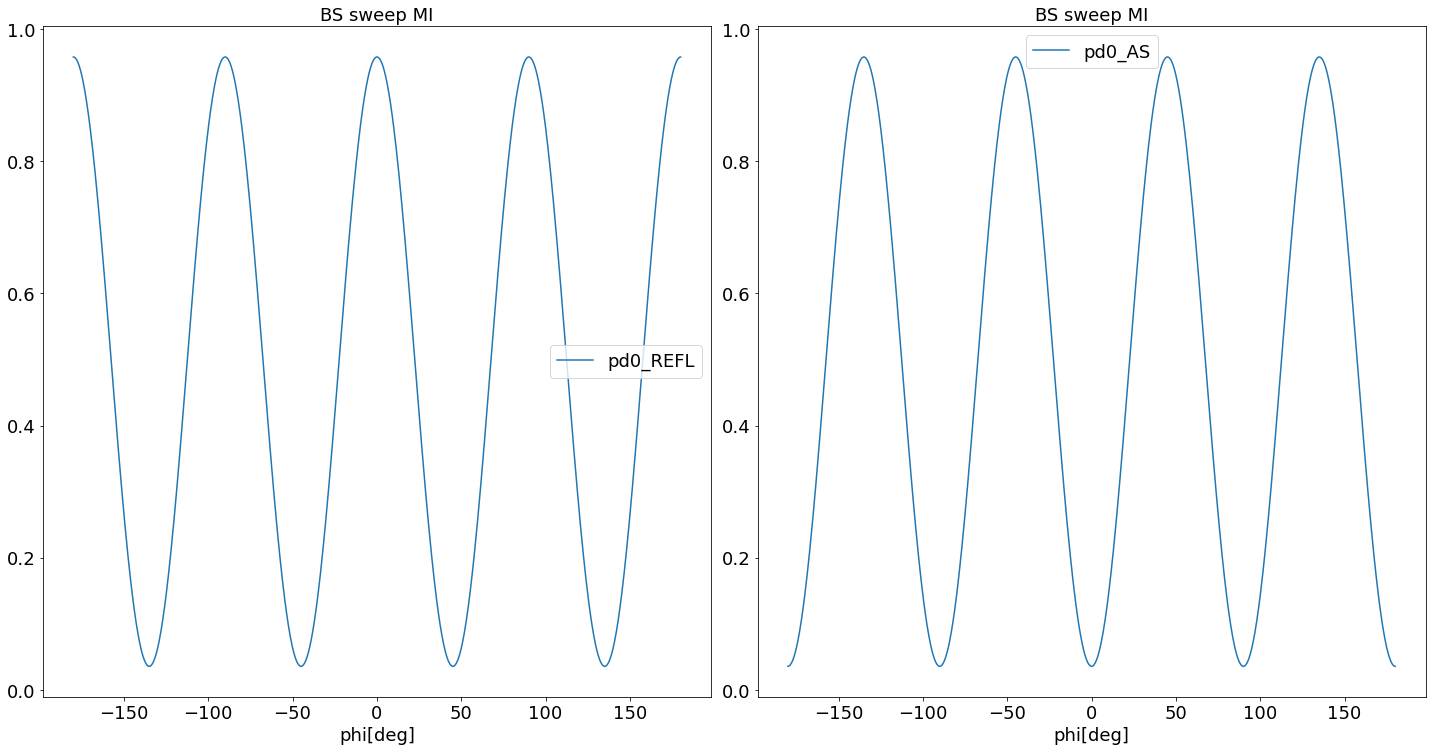

0123456789.-
0123456789.


### MI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2

        
## PDs ##

pd0 pd0_AS AS
pd0 pd0_REFL REFL
            
# BS scan
#
#(koyama) original vergion log kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi lin -180 180 1000
put* ITMY phi $mx1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-09-25 09:10:19.478958
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/

100% | ETA:  0:00:00 | Calculating                                             

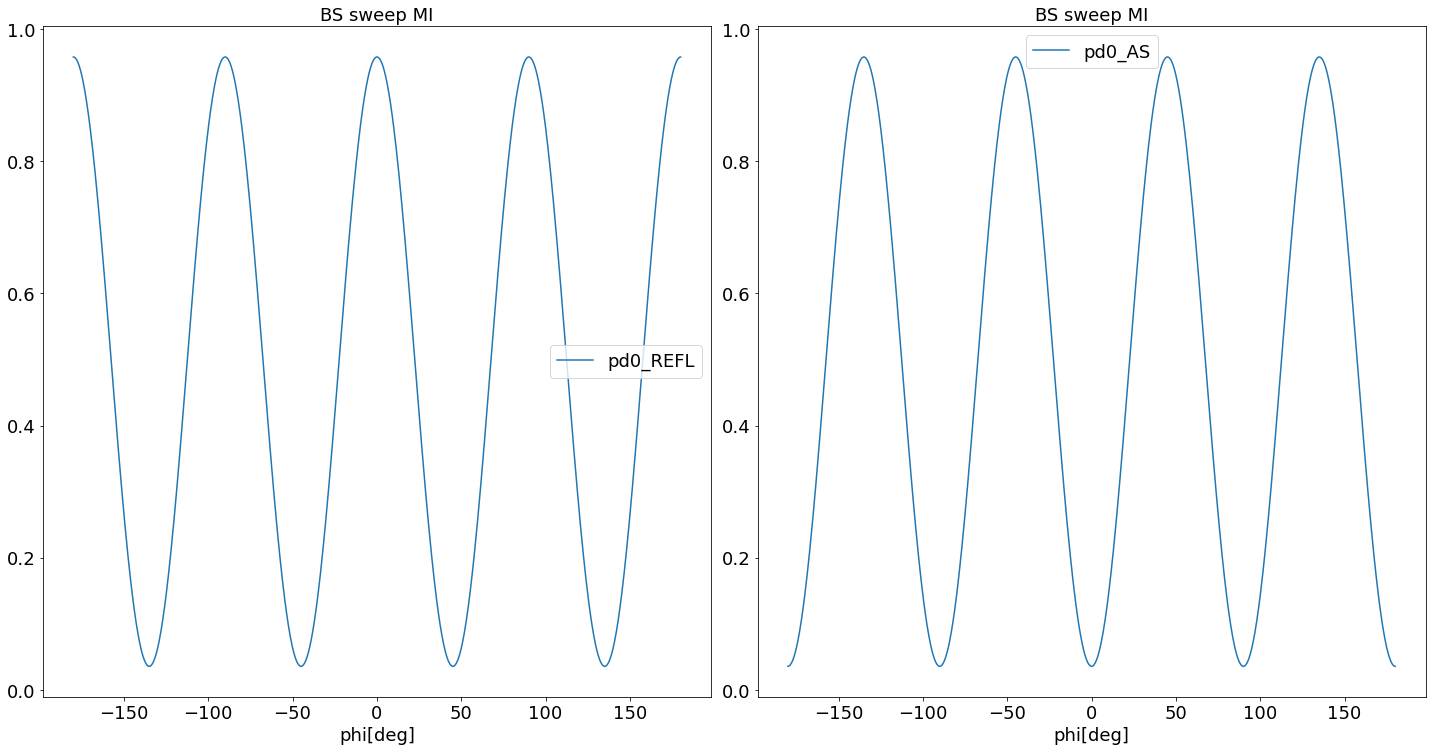

In [ ]:

######################################################################################################################################################
# GUIを作成
######################################################################################################################################################

##################################    
# drawing 
##################################
# FPMI
kFPMI_drawing_normalsize = [
                [sg.Image('./n_tmp_drawing/Fabry_Perot_MI_eom_drawing_normal.png', key='kFPMI_imageContainer',  size=(400,300))]#size=(800,600)
]
kFPMI_drawing_largesize = [
                [sg.Image('./n_tmp_drawing/Fabry_Perot_MI_eom_drawing_large.png', key='kFPMI_imageContainer2', size=(800,600))]#size=(800,600)
]

# PRFPMI
kPRFPMI_drawing_normalsize = [
                [sg.Image('./n_tmp_drawing/Power_Recycled_Fabry_Perot_MI_eom_drawing_normal.png', key='kPRFPMI_imageContainer',  size=(400,300))]#size=(800,600)
]
kPRFPMI_drawing_largesize = [
                [sg.Image('./n_tmp_drawing/Power_Recycled_Fabry_Perot_MI_eom_drawing_large.png', key='kPRFPMI_imageContainer2', size=(800,600))]#size=(800,600)
]
# kDRFPMI
kDRFPMI_drawing_normalsize = [
                [sg.Image('./n_tmp_drawing/Dual_Recycled_FPMI_drawing_normal.png', key='kDRFPMI_imageContainer',  size=(400,300))]#size=(800,600)
]
kDRFPMI_drawing_largesize = [
                [sg.Image('./n_tmp_drawing/Dual_Recycled_FPMI_drawing_large.png', key='kDRFPMI_imageContainer2', size=(800,600))]#size=(800,600)
]
# kMI
kMI_drawing_normalsize = [
                [sg.Image('./n_tmp_drawing/MI_eom_drawing_normal.png', key='kMI_imageContainer',  size=(400,300))]#size=(800,600)
]
kMI_drawing_largesize = [
                [sg.Image('./n_tmp_drawing/MI_eom_drawing_large.png', key='kMI_imageContainer2', size=(800,600))]#size=(800,600)
]
##################################    
# drawing size buttons
##################################
# kFPMI
kFPMI_drawing_size_buttons =[
                [sg.Button('normal size', size=(10,1), font=(10), key='kFPMI_normalize_drawing_size'), 
                 sg.Button('Large size',  size=(10,1), font=(10), key='kFPMI_expand_drawing_size')],
]
# kPRFPMI
kPRFPMI_drawing_size_buttons =[
                [sg.Button('normal size', size=(10,1), font=(10), key='kPRFPMI_normalize_drawing_size'), 
                 sg.Button('Large size',  size=(10,1), font=(10), key='kPRFPMI_expand_drawing_size')],
]
# kDRFPMI
kDRFPMI_drawing_size_buttons =[
                [sg.Button('normal size', size=(10,1), font=(10), key='kDRFPMI_normalize_drawing_size'), 
                 sg.Button('Large size',  size=(10,1), font=(10), key='kDRFPMI_expand_drawing_size')],
]
# kMI
kMI_drawing_size_buttons =[
                [sg.Button('normal size', size=(10,1), font=(10), key='kMI_normalize_drawing_size'), 
                 sg.Button('Large size',  size=(10,1), font=(10), key='kMI_expand_drawing_size')],
]
##################################    
#section setting pd0/pd1/pd2
##################################

#
# kFPMI
# 

# select sw_power or sw_dmod1
kFPMI_sec_sw_power_setting = [
            [sg.Text('no advanced settings')]
            ]
kFPMI_sec_sw_dmod1_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_sw_dmod1_plot', default=False, key='kFPMI_sw_dmod1_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_sw_dmod1_plot', default=True,  key='kFPMI_sw_dmod1_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kFPMI_pd1_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kFPMI_pd1_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kFPMI_pd1_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kFPMI_pd1_Qphase_fsb2')],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kFPMI_pd1_demod_phase', default_text='0', enable_events=True)]
            ]

# select tf_power or tf_dmod2
kFPMI_sec_tf_power_setting = [
            [sg.Text('no advanced settings')]
            ]
kFPMI_sec_tf_dmod2_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_tf_dmod2_plot', default=False, key='kFPMI_tf_dmod2_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_tf_dmod2_plot', default=True,  key='kFPMI_tf_dmod2_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kFPMI_pd2_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kFPMI_pd2_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kFPMI_pd2_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kFPMI_pd2_Qphase_fsb2'),],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kFPMI_pd2_demod_phase', default_text='0', enable_events=True)]
            ]

# select sw or tf
kFPMI_sec_sw_setting = [
            
            [sg.Text('Select pd0 or pd1.')],
            [sg.Radio('Power(pd0)',     'RADIO1', default=True,  key='kFPMI_issw_power', enable_events=True),
             sg.Radio('Demod_once(pd1)','RADIO1', default=False, key='kFPMI_issw_dmod1', enable_events=True)],
    
            ### pd0_setting_section
            [collapse(kFPMI_sec_sw_power_setting, 'kFPMI_sec_sw_power_setting')],
            ### pd1_settnig_section
            [collapse(kFPMI_sec_sw_dmod1_setting, 'kFPMI_sec_sw_dmod1_setting')]
    
            ]

kFPMI_sec_tf_setting = [
            
            [sg.Text('Select pd0 or pd2.')],
            [sg.Radio('Power(pd0)', 'pd2_RADIO', default=True,  key='kFPMI_istf_power', enable_events=True),
             sg.Radio('Demod(pd2)', 'pd2_RADIO', default=False, key='kFPMI_istf_dmod2', enable_events=True)],

            ### pd2_setting_section
            [collapse(kFPMI_sec_tf_power_setting, 'kFPMI_sec_tf_power_setting')],
            ### pd2_setting_section
            [collapse(kFPMI_sec_tf_dmod2_setting, 'kFPMI_sec_tf_dmod2_setting')]
    
            ]

#
# kPRFPMI
#

kPRFPMI_sec_sw_power_setting = [

            [sg.Text('no advanced settings')]
            ]
kPRFPMI_sec_sw_dmod1_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_sw_dmod1_plot', default=False, key='kPRFPMI_sw_dmod1_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_sw_dmod1_plot', default=True,  key='kPRFPMI_sw_dmod1_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kPRFPMI_pd1_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kPRFPMI_pd1_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kPRFPMI_pd1_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kPRFPMI_pd1_Qphase_fsb2')],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kPRFPMI_pd1_demod_phase', default_text='0', enable_events=True)]
            ]

# select tf_power or tf_dmod2
kPRFPMI_sec_tf_power_setting = [

            [sg.Text('no advanced settings')]
            ]
kPRFPMI_sec_tf_dmod2_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_tf_dmod2_plot', default=False, key='kPRFPMI_tf_dmod2_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_tf_dmod2_plot', default=True,  key='kPRFPMI_tf_dmod2_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kPRFPMI_pd2_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kPRFPMI_pd2_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kPRFPMI_pd2_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kPRFPMI_pd2_Qphase_fsb2'),],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kPRFPMI_pd2_demod_phase', default_text='0', enable_events=True)]
            ]

# select sw or tf
kPRFPMI_sec_sw_setting = [
    
            [sg.Radio('Power(pd0)',     'RADIO1', default=True,  key='kPRFPMI_issw_power', enable_events=True),
             sg.Radio('Demod_once(pd1)','RADIO1', default=False, key='kPRFPMI_issw_dmod1', enable_events=True)],
    
            ### pd0_setting_section
            [collapse(kPRFPMI_sec_sw_power_setting, 'kPRFPMI_sec_sw_power_setting')],
            ### pd1_settnig_section
            [collapse(kPRFPMI_sec_sw_dmod1_setting, 'kPRFPMI_sec_sw_dmod1_setting')]
    
            ]

kPRFPMI_sec_tf_setting = [
    
            [sg.Radio('Power(pd0)', 'pd2_RADIO', default=True,  key='kPRFPMI_istf_power', enable_events=True),
             sg.Radio('Demod(pd2)', 'pd2_RADIO', default=False, key='kPRFPMI_istf_dmod2', enable_events=True)],

            ### pd2_setting_section
            [collapse(kPRFPMI_sec_tf_power_setting, 'kPRFPMI_sec_tf_power_setting')],
            ### pd2_setting_section
            [collapse(kPRFPMI_sec_tf_dmod2_setting, 'kPRFPMI_sec_tf_dmod2_setting')]
    
            ]

#
# kDRFPMI
#

kDRFPMI_sec_sw_power_setting = [

            ]
kDRFPMI_sec_sw_dmod1_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_sw_dmod1_plot', default=False, key='kDRFPMI_sw_dmod1_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_sw_dmod1_plot', default=True,  key='kDRFPMI_sw_dmod1_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kDRFPMI_pd1_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kDRFPMI_pd1_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kDRFPMI_pd1_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kDRFPMI_pd1_Qphase_fsb2')],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kDRFPMI_pd1_demod_phase', default_text='0', enable_events=True)]
            ]

# select tf_power or tf_dmod2
kDRFPMI_sec_tf_power_setting = [

            ]
kDRFPMI_sec_tf_dmod2_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_tf_dmod2_plot', default=False, key='kDRFPMI_tf_dmod2_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_tf_dmod2_plot', default=True,  key='kDRFPMI_tf_dmod2_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kDRFPMI_pd2_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kDRFPMI_pd2_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kDRFPMI_pd2_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kDRFPMI_pd2_Qphase_fsb2'),],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kDRFPMI_pd2_demod_phase', default_text='0', enable_events=True)]
            ]

# select sw or tf
kDRFPMI_sec_sw_setting = [
    
            [sg.Radio('Power(pd0)',     'RADIO1', default=True,  key='kDRFPMI_issw_power', enable_events=True),
             sg.Radio('Demod_once(pd1)','RADIO1', default=False, key='kDRFPMI_issw_dmod1', enable_events=True)],
    
            ### pd0_setting_section
            [collapse(kDRFPMI_sec_sw_power_setting, 'kDRFPMI_sec_sw_power_setting')],
            ### pd1_settnig_section
            [collapse(kDRFPMI_sec_sw_dmod1_setting, 'kDRFPMI_sec_sw_dmod1_setting')]
    
            ]

kDRFPMI_sec_tf_setting = [
    
            [sg.Radio('Power(pd0)', 'pd2_RADIO', default=True,  key='kDRFPMI_istf_power', enable_events=True),
             sg.Radio('Demod(pd2)', 'pd2_RADIO', default=False, key='kDRFPMI_istf_dmod2', enable_events=True)],

            ### pd2_setting_section
            [collapse(kDRFPMI_sec_tf_power_setting, 'kDRFPMI_sec_tf_power_setting')],
            ### pd2_setting_section
            [collapse(kDRFPMI_sec_tf_dmod2_setting, 'kDRFPMI_sec_tf_dmod2_setting')]
    
            ]

#
# kMI
#

kMI_sec_sw_power_setting = [

            ]
kMI_sec_sw_dmod1_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_sw_dmod1_plot', default=False, key='kMI_sw_dmod1_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_sw_dmod1_plot', default=True,  key='kMI_sw_dmod1_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kMI_pd1_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kMI_pd1_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kMI_pd1_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kMI_pd1_Qphase_fsb2')],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kMI_pd1_demod_phase', default_text='0', enable_events=True)]
            ]

# select tf_power or tf_dmod2
kMI_sec_tf_power_setting = [

            ]
kMI_sec_tf_dmod2_setting = [
    
            [sg.Text('if select "plot separately", pd results displayed all separately.')],
            [sg.Radio('overplot selected port', 'RADIO_tf_dmod2_plot', default=False, key='kMI_tf_dmod2_overplot', enable_events=True),
             sg.Radio('plot separately',        'RADIO_tf_dmod2_plot', default=True,  key='kMI_tf_dmod2_sepaplot', enable_events=True)],
            [sg.Text('Which phase to plot?')],

            [sg.Checkbox('I_fsb1(in_phase f1)',         key='kMI_pd2_Iphase_fsb1'),
             sg.Checkbox('Q_fsb1(quadrature_phase f1)', key='kMI_pd2_Qphase_fsb1'),
             sg.Checkbox('I_fsb2(in_phase f2)',         key='kMI_pd2_Iphase_fsb2'),
             sg.Checkbox('Q_fsb2(quadrature_phase f2)', key='kMI_pd2_Qphase_fsb2'),],
    
            [sg.Text('Demodulation_phase'),sg.Input(key='kMI_pd2_demod_phase', default_text='0', enable_events=True)]
            ]

# select sw or tf
kMI_sec_sw_setting = [
    
            [sg.Radio('Power(pd0)',     'RADIO1', default=True,  key='kMI_issw_power', enable_events=True),
             sg.Radio('Demod_once(pd1)','RADIO1', default=False, key='kMI_issw_dmod1', enable_events=True)],
    
            ### pd0_setting_section
            [collapse(kMI_sec_sw_power_setting, 'kMI_sec_sw_power_setting')],
            ### pd1_settnig_section
            [collapse(kMI_sec_sw_dmod1_setting, 'kMI_sec_sw_dmod1_setting')]
    
            ]

kMI_sec_tf_setting = [
    
            [sg.Radio('Power(pd0)', 'pd2_RADIO', default=True,  key='kMI_istf_power', enable_events=True),
             sg.Radio('Demod(pd2)', 'pd2_RADIO', default=False, key='kMI_istf_dmod2', enable_events=True)],

            ### pd2_setting_section
            [collapse(kMI_sec_tf_power_setting, 'kMI_sec_tf_power_setting')],
            ### pd2_setting_section
            [collapse(kMI_sec_tf_dmod2_setting, 'kMI_sec_tf_dmod2_setting')]
    
            ]
##################################    
#TAB select FPMI/PRFPMI/DRFPMI
##################################

#
#kFPMI_tab
#

kFPMI_layout = [
[collapse(kFPMI_drawing_normalsize, 'kFPMI_drawing_normalsize')],
[collapse(kFPMI_drawing_largesize,  'kFPMI_drawing_largesize')],
# Drawing
[sg.Column(kFPMI_drawing_size_buttons, justification="right")],
### select section sw or tf / power, dmod1 or dmod2
[sg.Text('1. Select Sweep or Transfer function', font=('System',20))],
[sg.Radio('Sweep',                  'HOW_SIMULATE01', default=True,  key='kFPMI_issw', enable_events=True),
 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, key='kFPMI_istf', enable_events=True)],

[collapse(kFPMI_sec_sw_setting, 'kFPMI_sec_sw_setting')],
[collapse(kFPMI_sec_tf_setting, 'kFPMI_sec_tf_setting')],

# select DARM, CARM or BS
[sg.Text('2. Select which Dof to move', font=('System',20))],
[sg.Text("note: Please do not type DoF, just select it from choices.")],
[sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS'), size=(20,1), default_value='DARM', key='kFPMI_dof')], #sg.comboを使う時にはサイズを指定するべき

## PDs checkbox
[sg.Text('3. Select port (see the top figure)', font=('System',20))],#図と関連あるとかく

[sg.Checkbox('REFL', default=True, key='kFPMI_REFL'), sg.Checkbox('AS',    default=True, key='kFPMI_AS'),
sg.Checkbox('nTMSY', default=True, key='kFPMI_nTMSY'),sg.Checkbox('nTMSX', default=True, key='kFPMI_nTMSX')],

[sg.Checkbox('n2', text_color='black', key='kFPMI_n2'), sg.Checkbox('n3',  key='kFPMI_n3'),
sg.Checkbox('ny1', key='kFPMI_ny1'),sg.Checkbox('nx1', key='kFPMI_nx1'),
sg.Checkbox('ny2', key='kFPMI_ny2'),sg.Checkbox('nx2', key='kFPMI_nx2'),
sg.Checkbox('ny3', key='kFPMI_ny3'),sg.Checkbox('nx3', key='kFPMI_nx3')],
# plot button
[sg.Button('Plot', button_color=('white', 'black'), key='kFPMI_event'), 
 sg.Text("     "), 
 sg.Button('Check all important port', key='kFPMI_set_all_important_port_bool'), 
 sg.Button(  'Check all port',         key='kFPMI_check_all_port'), 
 sg.Button('Uncheck all port',         key='kFPMI_uncheck_all_port')],
]

#
#kPRFPMI
#

kPRFPMI_layout = [
[collapse(kPRFPMI_drawing_normalsize, 'kPRFPMI_drawing_normalsize')],
[collapse(kPRFPMI_drawing_largesize,  'kPRFPMI_drawing_largesize')],

# Drawing
[sg.Column(kPRFPMI_drawing_size_buttons, justification="right")],
### select section sw or tf / power, dmod1 or dmod2
[sg.Text('1. Select Sweep or Transfer function ', font=('System',20))],
[sg.Radio('Sweep',                  'HOW_SIMULATE01', default=True,  key='kPRFPMI_issw', enable_events=True),
 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, key='kPRFPMI_istf', enable_events=True)],

[collapse(kPRFPMI_sec_sw_setting, 'kPRFPMI_sec_sw_setting')],
[collapse(kPRFPMI_sec_tf_setting, 'kPRFPMI_sec_tf_setting')],

# select DARM, CARM or BS
[sg.Text('2. Select which Dof to move', font=('System',20))],
[sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS', 'PRCL'), size=(20,1), default_value='DARM', key='kPRFPMI_dof')], #sg.comboを使う時にはサイズを指定するべき

## PDs checkbox
[sg.Text('3. Select port (see the top figure)', font=('System',20))],#図と関連あるとかく

[sg.Checkbox('REFL', default=True, key='kPRFPMI_REFL'), sg.Checkbox('AS',    default=True, key='kPRFPMI_AS'),
 sg.Checkbox('POP',  default=True, key='kPRFPMI_POP'),  sg.Checkbox('POP2',  default=True, key='kPRFPMI_POP2'),
 sg.Checkbox('nTMSY',default=True, key='kPRFPMI_nTMSY'),sg.Checkbox('nTMSX', default=True, key='kPRFPMI_nTMSX')],
[sg.Checkbox('npr1', key='kPRFPMI_npr1'),sg.Checkbox('npr2', key='kPRFPMI_npr2'),
 sg.Checkbox('npr3', key='kPRFPMI_npr3'),sg.Checkbox('npr4', key='kPRFPMI_npr4'),
 sg.Checkbox('npr5', key='kPRFPMI_npr5'),sg.Checkbox('npr6', key='kPRFPMI_npr6')],
[sg.Checkbox('n2',   key='kPRFPMI_n2'),  sg.Checkbox('n3',   key='kPRFPMI_n3'),
 sg.Checkbox('ny1',  key='kPRFPMI_ny1'), sg.Checkbox('nx1',  key='kPRFPMI_nx1'),
 sg.Checkbox('ny2',  key='kPRFPMI_ny2'), sg.Checkbox('nx2',  key='kPRFPMI_nx2'),
 sg.Checkbox('ny3',  key='kPRFPMI_ny3'), sg.Checkbox('nx3',  key='kPRFPMI_nx3')],

# plot button
[sg.Button('Plot', button_color=('white', 'black'), key='kPRFPMI_event'),
 sg.Text("     "), 
 sg.Button('Check all important port', key='kPRFPMI_set_all_important_port_bool'), 
 sg.Button(  'Check all port',         key='kPRFPMI_check_all_port'), 
 sg.Button('Uncheck all port',         key='kPRFPMI_uncheck_all_port')]
]

#
#kDRFPMI_tab
#

kDRFPMI_layout = [
[collapse(kDRFPMI_drawing_normalsize, 'kDRFPMI_drawing_normalsize')],
[collapse(kDRFPMI_drawing_largesize,  'kDRFPMI_drawing_largesize')],

# Drawing
[sg.Column(kDRFPMI_drawing_size_buttons, justification="right")],
### select section sw or tf / power, dmod1 or dmod2
[sg.Text('1. Select Sweep or Transfer function ', font=('System',20))],
[sg.Radio('Sweep',                  'HOW_SIMULATE01', default=True,  key='kDRFPMI_issw', enable_events=True),
 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, key='kDRFPMI_istf', enable_events=True)],

[collapse(kDRFPMI_sec_sw_setting, 'kDRFPMI_sec_sw_setting')],
[collapse(kDRFPMI_sec_tf_setting, 'kDRFPMI_sec_tf_setting')],

# select DARM, CARM or BS
[sg.Text('2. Select which Dof to move', font=('System',20))],
[sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS', 'PRCL', 'SRCL'), size=(20,1), default_value='DARM', key='kDRFPMI_dof')], #sg.comboを使う時にはサイズを指定するべき

## PDs checkbox
[sg.Text('3. Select port (see the top figure)', font=('System',20))],#図と関連あるとかく

[sg.Checkbox('REFL', default=True, key='kDRFPMI_REFL'), sg.Checkbox('AS',   default=True, key='kDRFPMI_AS'),
 sg.Checkbox('POP',  default=True, key='kDRFPMI_POP'),  sg.Checkbox('POP2', default=True, key='kDRFPMI_POP2'),
 sg.Checkbox('nTMSY',default=True, key='kDRFPMI_nTMSY'),sg.Checkbox('nTMSX',default=True, key='kDRFPMI_nTMSX'),
 sg.Checkbox('POS',  default=True, key='kDRFPMI_POS')],
[sg.Checkbox('npr1', key='kDRFPMI_npr1'),sg.Checkbox('npr2',  key='kDRFPMI_npr2'),# npr
 sg.Checkbox('npr3', key='kDRFPMI_npr3'),sg.Checkbox('npr4',  key='kDRFPMI_npr4'),
 sg.Checkbox('npr5', key='kDRFPMI_npr5'),sg.Checkbox('npr6',  key='kDRFPMI_npr6')],
[sg.Checkbox('nsr1', key='kDRFPMI_nsr1'),sg.Checkbox('nsr2',  key='kDRFPMI_nsr2'),# nsr
 sg.Checkbox('nsr3', key='kDRFPMI_nsr3'),sg.Checkbox('nsr4',  key='kDRFPMI_nsr4'),
 sg.Checkbox('nsr5', key='kDRFPMI_nsr5')],
[sg.Checkbox('n2',   key='kDRFPMI_n2'), sg.Checkbox('n3',   key='kDRFPMI_n3'),# n
 sg.Checkbox('ny1',  key='kDRFPMI_ny1'),sg.Checkbox('nx1',  key='kDRFPMI_nx1'),
 sg.Checkbox('ny2',  key='kDRFPMI_ny2'),sg.Checkbox('nx2',  key='kDRFPMI_nx2'),
 sg.Checkbox('ny3',  key='kDRFPMI_ny3'),sg.Checkbox('nx3',  key='kDRFPMI_nx3')],

# plot button
[sg.Button('Plot', button_color=('white', 'black'), key='kDRFPMI_event'),
 sg.Text("     "), 
 sg.Button('Check all important port', key='kDRFPMI_set_all_important_port_bool'), 
 sg.Button(  'Check all port',         key='kDRFPMI_check_all_port'), 
 sg.Button('Uncheck all port',         key='kDRFPMI_uncheck_all_port')]
]

#
#kMI_tab
#

kMI_layout = [  
[collapse(kMI_drawing_normalsize, 'kMI_drawing_normalsize')],
[collapse(kMI_drawing_largesize,  'kMI_drawing_largesize')],

# Drawing
[sg.Column(kMI_drawing_size_buttons, justification="right")],
### select section sw or tf / power, dmod1 or dmod2
[sg.Text('1. Select Sweep or Transfer function ', font=('System',20))],
[sg.Radio('Sweep',                  'HOW_SIMULATE01', default=True,  key='kMI_issw', enable_events=True),
 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, key='kMI_istf', enable_events=True)],

[collapse(kMI_sec_sw_setting, 'kMI_sec_sw_setting')],
[collapse(kMI_sec_tf_setting, 'kMI_sec_tf_setting')],

# select DARM, CARM or BS
[sg.Text('2. Select which Dof to move', font=('System',20))],
[sg.Text('　　DoF'),sg.Combo(('BS', ''), size=(20,1), default_value='BS', key='kMI_dof')], #sg.comboを使う時にはサイズを指定するべき # BSだけだとなぜか'B'になるエラーがある

## PDs checkbox
[sg.Text('3. Select port (see the top figure)', font=('System',20))],#図と関連あるとかく
[sg.Checkbox('REFL', default=True, key='kMI_REFL'), sg.Checkbox('AS',    default=True, key='kMI_AS')],
[sg.Checkbox('n2',   key='kMI_n2'),  sg.Checkbox('n3',   key='kMI_n3'),
 sg.Checkbox('ny1',  key='kMI_ny1'), sg.Checkbox('nx1',  key='kMI_nx1'),
 sg.Checkbox('ny2',  key='kMI_ny2'), sg.Checkbox('nx2',  key='kMI_nx2')],

# plot button
[sg.Button('Plot', button_color=('white', 'black'), key='kMI_event'),
 sg.Text("     "), 
 sg.Button('Check all important port', key='kMI_set_all_important_port_bool'), 
 sg.Button(  'Check all port',         key='kMI_check_all_port'), 
 sg.Button('Uncheck all port',         key='kMI_uncheck_all_port')]
]

##################################
### EXTRA OPTION TAB
##################################
extra_option_tab =  [
                #other settings
                [sg.Text('laser_power [W]'), sg.Input(key='k_inf_c_laser_power',     default_text='1')],
                [sg.Text('PRC mirror loss'), sg.Input(key='k_inf_c_prc_mirror_loss', default_text='40e-6', enable_events=True)],
                [sg.Text('SRC mirror loss'), sg.Input(key='k_inf_c_src_mirror_loss', default_text='40e-6', enable_events=True)],
                ### xaxis range
                [sg.Radio('xaxis lin', 'x_plotscale', default=True,  key='k_inf_c_xaxis_lin', enable_events=True),
                 sg.Radio('xaxis log', 'x_plotscale', default=False, key='k_inf_c_xaxis_log', enable_events=True)],
                ### yaxis range
                [sg.Radio('yaxis lin', 'y_plotscale', default=True,  key='k_inf_c_yaxis_lin', enable_events=True),
                 sg.Radio('yaxis log', 'y_plotscale', default=False, key='k_inf_c_yaxis_log', enable_events=True)],
     
                [sg.Text('sampling num'), sg.Input(key='k_inf_c_samplingnum', default_text='1000', enable_events=True)],
    
                [sg.Text('Which data you output?')],
                [sg.Checkbox('kat file', key='k_inf_c_output_kat'), 
                 sg.Checkbox('plotdata', key='k_inf_c_output_plotdata')]
                ]

# 
L1 = [
    # Tab Group
    [sg.TabGroup([[sg.Tab('FPMI',   kFPMI_layout), 
                   sg.Tab('PRFPMI', kPRFPMI_layout), 
                   sg.Tab('DRFPMI', kDRFPMI_layout), 
                   sg.Tab('MI',     kMI_layout), 
                   sg.Tab('OPTION', extra_option_tab)]], enable_events=True, key="kselected_tab")],
    # xaxis range
    [sg.Text('xaxis range', key='k_inf_c_xaxis_range_text')],
    [sg.Input(key='k_inf_c_xaxis_range_beg', default_text='-180', enable_events=True), 
     sg.Text('to'),
     sg.Input(key='k_inf_c_xaxis_range_end', default_text= '180', enable_events=True)],
    
    # その他ボタン
    [sg.Checkbox('overplot All PDs', key='k_inf_c_is_overplot_all_pds')]
]
    
layout = [
    [sg.Frame("",L1, key="layoutkey")]#作成したGUIを枠線で囲む
] 
col = [
    [sg.Column(layout, key="colkey", scrollable=True, vertical_scroll_only=True)]#枠戦で囲んだGUIをスクロールできるようにする
]

window = sg.Window('finesse GUI', col, default_element_size=(15,1), finalize=True, size=(900,700), resizable=True, auto_size_text=True)   

######################################################################################################################################################
# GUI上のボタンを押した時にどんな動作をするか
######################################################################################################################################################
type_of_pd_signal =''
initialization = False
should_check_all_important_port = True
can_start_finesse = False
#default
type_of_pd_signal = 'sw_power'#一番最初に表示する画面　デフォルト
selected_tab      = "FPMI"
dof_move          = "sweep"
limited_range     = '0123456789.-'
window['kselected_tab'].expand(expand_x=True)# tabの中にあるオブジェクトのサイズに応じてtabのサイズを横幅いっぱいになるように変更する
window['layoutkey'].expand(expand_x=True)# 枠で囲ったGUIのサイズに応じて枠のサイズを幅いっぱいになるように変更する

while True:
    # GUIを立ち上げた時に一度だけ実行する
    if(initialization==False):
        
        # 関数名　　　　　：set_gui_window_visible_true
        # 内容　　　　　　：第一引数で渡した名前のセクションを第二引数がTrueなら開く、Falseなら閉じる
        # 引数　　　　　　：target_section_keys, should_be_visible
        # 返値　　　　　　：
        # 使っている変数　：
        set_gui_window_visible_true(all_gui_section_keys, False)#pdの設定をするためのsectionをすべて閉じる
        
        # 関数名　　　　　：set_gui_window_bool_true
        # 内容　　　　　　：第一引数で渡した名前のGUIオブジェクトを第二引数の真偽値の値にする
        # 引数　　　　　　：radiobox_keys, selected_tab
        # 返値　　　　　　：
        # 使っている変数　：
        set_gui_window_bool_true(all_radiobox_keys, False)#pdの設定をするためのRADIOBOXの値を全部Falseにする

        # 関数名　　　　　： set_drawing_size_enlarge
        # 内容　　　　　　： 第一引数で指定されたタブの図のサイズを第二引数がTrueなら拡大し、Falseなら通常に戻す
        # 引数　　　　　　： selected_tab, enlarge_flag
        # 返値　　　　　　：
        # 使っている変数　： all_interferometers
        set_drawing_size_enlarge(selected_tab, False)# #GUIを立ち上げた時には通常サイズと大きいサイズの図が両方表示されるから普通のサイズの図だけ表示されるようにする。
        
        initialization = True
        
    event, values = window.read()
    
    # close button
    if event == sg.WIN_CLOSED:
        break

    # select tab
    if event == "kselected_tab":
        selected_tab = values["kselected_tab"]
        if selected_tab=="OPTION":
            continue
        else:
            ####### initializeと共通なのでなんとかする

            set_gui_window_visible_true(all_gui_section_keys, False)#pdの設定をするためのsectionをすべて閉じる

            set_gui_window_bool_true(all_radiobox_keys, False)#pdの設定をするためのRADIOBOXの値を全部Falseにする

            set_drawing_size_enlarge(selected_tab, False)# #GUIを立ち上げた時には通常サイズと大きいサイズの図が両方表示されるから普通のサイズの図だけ表示されるようにする。

            change_GUI_plotscale(["lin","lin"], True)
            limited_range     = '0123456789.-'
            
            dof_move          = "sweep"
            type_of_pd_signal = 'sw_power'
            can_start_finesse = False

    # drawing normal/large size button
    if event == 'k%s_normalize_drawing_size'%selected_tab:
        if selected_tab=="OPTION":
            continue
        else:
            # 関数名　　　　　：set_drawing_size_enlarge
            # 内容　　　　　　：第一引数で指定されたタブの図のサイズを第二引数がTrueなら拡大し、Falseなら通常に戻す
            # 引数　　　　　　：selected_tab, enlarge_flag
            # 返値　　　　　　：
            # 使っている変数　：
            set_drawing_size_enlarge(selected_tab, False)
    if event == 'k%s_expand_drawing_size'%selected_tab:
        if selected_tab=="OPTION":
            continue
        else:
            set_drawing_size_enlarge(selected_tab, True)
            
    # limit xaxis value
    if event == 'k_inf_c_xaxis_range_beg' and values['k_inf_c_xaxis_range_beg'] and values['k_inf_c_xaxis_range_beg'][-1] not in (limited_range):# limited_range に含まれている文字しか入力できなくする
        window['k_inf_c_xaxis_range_beg'].update(values['k_inf_c_xaxis_range_beg'][:-1])
    if event == 'k_inf_c_xaxis_range_end' and values['k_inf_c_xaxis_range_end'] and values['k_inf_c_xaxis_range_end'][-1] not in (limited_range):# limited_range に含まれている文字しか入力できなくする
        window['k_inf_c_xaxis_range_end'].update(values['k_inf_c_xaxis_range_end'][:-1])
        
    ### update xaxis default value
    if event == 'k_inf_c_xaxis_lin':
        change_GUI_plotscale(["lin","no change"], True)
        limited_range     = '0123456789.-'
        print(limited_range)
    if event == 'k_inf_c_xaxis_log':
        change_GUI_plotscale(["log","no change"], True)
        limited_range     = '0123456789.'
        print(limited_range)
        
    ### port select button
    if event == "k%s_set_all_important_port_bool"%selected_tab:
        if should_check_all_important_port:
            set_gui_port_bool(values, selected_tab, all_important_ports, False)
            should_check_all_important_port = False
        else:
            set_gui_port_bool(values, selected_tab, all_important_ports, True)
            should_check_all_important_port = True
    if event == "k%s_check_all_port"%selected_tab:
        set_gui_port_bool(values, selected_tab, all_ports, True)  
        should_check_all_important_port = True
    if event == "k%s_uncheck_all_port"%selected_tab:
        set_gui_port_bool(values, selected_tab, all_ports, False)  
        should_check_all_important_port = False
                
    ### visible/invisible advanced setting
    
    # sw: sweep
    #
    # issw: sweep/transferfunction で sweep を選択するフラグ
    # issw_power: sweepの時にpd0をポートに置く設定のフラグ
    # issw_dmod1: sweepの時にpd1をポートに置く設定のフラグ
    #
    
    if event == 'k%s_issw'%selected_tab:# Sweepを選択した時
        # windowkeysに含まれるwindowを開く
        windowkeys  = ["k%s_sec_sw_setting"%selected_tab]
        # sectionkeysに含まれるオブジェクトの真偽値を変更する
        sectionkeys = ["k%s_issw"          %selected_tab]
        set_gui_window_visible_true(all_gui_section_keys, False)
        set_gui_window_bool_true(all_radiobox_keys, False)
        set_gui_window_visible_true(windowkeys, True)
        set_gui_window_bool_true(sectionkeys, True)
        # default plot scale
        change_GUI_plotscale(["lin","no change"], True)
        limited_range     = '0123456789.-'
        # 選択した干渉計の動作と測定の方法
        dof_move          = "sweep"
        type_of_pd_signal = 'sw_power'
        can_start_finesse = False
    # sw_power
    if event == 'k%s_issw_power'%selected_tab:
        
        windowkeys  = ["k%s_sec_sw_setting"      %selected_tab, 
                       "k%s_sec_sw_power_setting"%selected_tab]
        sectionkeys = ["k%s_issw"      %selected_tab, 
                       "k%s_issw_power"%selected_tab]
        set_gui_window_visible_true(all_gui_section_keys, False)
        set_gui_window_bool_true(all_radiobox_keys, False)
        set_gui_window_visible_true(windowkeys, True)
        set_gui_window_bool_true(sectionkeys, True)
        
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        change_GUI_plotscale(["lin","no change"], True)
    
        type_of_pd_signal = 'sw_power'
        can_start_finesse = True
    # sw_dmod1
    if event == 'k%s_issw_dmod1'%selected_tab:
        
        windowkeys  = ["k%s_sec_sw_setting"      %selected_tab,# sw
                       "k%s_sec_sw_dmod1_setting"%selected_tab,# dmod1
                      ]
        
        sectionkeys = ["k%s_issw"             %selected_tab,# sw
                       "k%s_issw_dmod1"       %selected_tab,# dmod1
                       "k%s_sw_dmod1_sepaplot"%selected_tab # デフォルトのplotの方法
                      ]
        set_gui_window_visible_true(all_gui_section_keys, False)
        set_gui_window_bool_true(all_radiobox_keys, False)
        set_gui_window_visible_true(windowkeys, True)
        set_gui_window_bool_true(sectionkeys, True)
        
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        change_GUI_plotscale(["lin","no change"], True)
        
        type_of_pd_signal = 'sw_dmod1'
        can_start_finesse = True
        
    # tf: transfet function
    #
    # istf: sweep/transferfunction で transferfunction を選択するフラグ
    # istf_power: transferfunctionの時にpd0をポートに置く設定のフラグ
    # istf_dmod2: transferfunctionの時にpd2をポートに置く設定のフラグ
    #
    
    if event == 'k%s_istf'%selected_tab:# Transferfunctionを選択した時
        #visible/not visible
        windowkeys  = ["k%s_sec_tf_setting"%selected_tab]
        sectionkeys = ["k%s_istf"          %selected_tab]
        set_gui_window_visible_true(all_gui_section_keys, False)
        set_gui_window_bool_true(all_radiobox_keys, False)
        set_gui_window_visible_true(windowkeys, True)
        set_gui_window_bool_true(sectionkeys, True)
        #default value
        change_GUI_plotscale(["log","no change"], True)
        limited_range     = '0123456789.'
        # variables
        dof_move          = "transferfunction"
        type_of_pd_signal = 'tf_power'
        can_start_finesse = False
    # tf_power
    if event == 'k%s_istf_power'%selected_tab:
        
        windowkeys  = ["k%s_sec_tf_setting"      %selected_tab, 
                       "k%s_sec_tf_power_setting"%selected_tab]
        sectionkeys = ["k%s_istf"      %selected_tab, 
                       "k%s_istf_power"%selected_tab]
        set_gui_window_visible_true(all_gui_section_keys, False)
        set_gui_window_bool_true(all_radiobox_keys, False)
        set_gui_window_visible_true(windowkeys, True)
        set_gui_window_bool_true(sectionkeys, True)
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        change_GUI_plotscale(["log","no change"], True)

        type_of_pd_signal = 'tf_power'
        can_start_finesse = True
    # tf_dmod2
    if event == 'k%s_istf_dmod2'%selected_tab:
        
        windowkeys  = ["k%s_sec_tf_setting"      %selected_tab, 
                       "k%s_sec_tf_dmod2_setting"%selected_tab]
        sectionkeys = ["k%s_istf"             %selected_tab, 
                       "k%s_istf_dmod2"       %selected_tab,
                       "k%s_tf_dmod2_sepaplot"%selected_tab #デフォルトのplotの方法
                      ]
        set_gui_window_visible_true(all_gui_section_keys, False)
        set_gui_window_bool_true(all_radiobox_keys, False)
        set_gui_window_visible_true(windowkeys, True)
        set_gui_window_bool_true(sectionkeys, True)
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis f[Hz] range')
        change_GUI_plotscale(["log","no change"], True)

        type_of_pd_signal = 'tf_dmod2'
        can_start_finesse = True
        
#######################################################################################################################################
#
# finesse のシミュレーション結果をmatplotlibを使って表示する
#
# code: シミュレーションを行うためにfinesseに渡したkat
# out: シミュレーションの結果
# 結果の表示方法３種類にした:全部overplot/portごとに分ける/全部バラバラに表示
#######################################################################################################################################

    # plotボタンを押した時の動作、シミュレーションを実行して結果を表示する   
    if event == 'k%s_event'%selected_tab:
        # initialize
        # この辺をどこかの関数に入れてまとめておくといいと思う
        sw_dmod1_overplot, tf_dmod2_overplot = False, False # GUIで選択してTrueのときは結果を表示する時にポートは分けてI1.Q1などはoverplotする
        
        if values["k%s_tf_dmod2_overplot"%selected_tab]:
            tf_dmod2_overplot = True
        if values["k%s_sw_dmod1_overplot"%selected_tab]:
            sw_dmod1_overplot = True
            
        if(values['k_inf_c_xaxis_log'] == True):
            x_plotscale = 'log'
        else:
            x_plotscale = 'linear'
        if(values['k_inf_c_yaxis_log'] == True):
            y_plotscale = 'log'
        else:
            y_plotscale = 'linear' 
            
        #########
        dic_advanced_setting = {
            ### DoF
            'dof'              :values['k%s_dof'%selected_tab],#str
            'type_of_pd_signal':type_of_pd_signal,#str sw_power/sw_dmod1/tf_power/tf_dmod2
            ### advanced setting
            'laser_power'      :values['k_inf_c_laser_power'],#str
            'prc_mirror_loss'  :values['k_inf_c_prc_mirror_loss'],#str
            'src_mirror_loss'  :values['k_inf_c_src_mirror_loss'],#str
            'x_plotscale'      :x_plotscale,#str log/linear
            'xaxis_range_beg'  :values['k_inf_c_xaxis_range_beg'],#str #x軸の最小値
            'xaxis_range_end'  :values['k_inf_c_xaxis_range_end'],#str #x軸の最大値
            'y_plotscale'      :y_plotscale,#str log/linear
            'pd1_demod_phase'  :values['k%s_pd1_demod_phase'%selected_tab],#str
            'pd2_demod_phase'  :values['k%s_pd2_demod_phase'%selected_tab],#str
            'samplingnum'      :values['k_inf_c_samplingnum'],#str
            }

        # 全部overplotするかどうか
        is_overplot_all_pds = values["k_inf_c_is_overplot_all_pds"]
        
        kat = finesse.kat()
        
        # 関数名　　　　　：make_dic_selected_setting_from_gui
        # 内容　　　　　　：GUIで選択した設定とそれを加工して作った変数を辞書でまとめて返す。
        # 引数　　　　　　：values, selected_tab, type_of_pd_signal
        # 返値　　　　　　：dic_selected_setting_from_gui
        # 使っている変数　：all_ports, all_pdname_heads, all_demod_freqs, all_demod_phases
        dic_selected_setting_from_gui = make_dic_selected_setting_from_gui(values, selected_tab, type_of_pd_signal)
        
        port_trues        = dic_selected_setting_from_gui["port_trues"]
        pdname_head       = dic_selected_setting_from_gui["pdname_head"]
        pdname_tails      = dic_selected_setting_from_gui["pdname_tails"]
        
        # finesseを実行する前にGUIで必要な設定がすべてできているかチェックする
        # sw_power sw_dmod1 tf_power tf_dmod2 などが選ばれていない
        if can_start_finesse == False:
            sg.popup_ok('Error : Please follow the instructions on the screen to set up your pd.')
            continue
        if type_of_pd_signal=="sw_power" or type_of_pd_signal=="tf_power":
            if len(port_trues)==0:
                sg.popup_ok('Error : Please check at least one pd port.')
                continue
        else:
            if len(port_trues)==0 or len(pdname_tails)==0:
                sg.popup_ok('Error : Please check at least one pd port or one demodulation phase.')
                continue
            
        # 関数名　　　　　：make_pd_kat_for_finesse
        # 内容　　　　　　：関数 make_dic_selected_setting_from_gui で作成した辞書を使って、finesseでノードに置くpdのテキストを作る
        # 引数　　　　　　：dic_selected_setting_from_gui
        # 返値　　　　　　：pds_for_kat
        # 使っている変数　：all_pdname_tails_i, all_pdname_tails_q
        pds_for_kat = make_pd_kat_for_finesse(dic_selected_setting_from_gui)
        
        # 関数名　　　　　：generate_kat
        # 内容　　　　　　：GUIで選択した設定のfinesseのkatテキストを作成する
        # 引数　　　　　　：pds_for_kat, dic_advanced_setting, selected_interferometer
        # 返値　　　　　　：code
        # 使っている変数　：
        code = generate_kat(pds_for_kat, dic_advanced_setting, selected_tab)
        
        kat.parse(code)
        out = kat.run()


        # katファイルや結果をoutputする用のlist
        # どこかの関数の中に入れたほうがいい気もする
        # 多分ここ make_pd_kat_for_finesse
        pdnames = []

        plot_title = '%s %s %s' % (values['k%s_dof'%selected_tab], dof_move, selected_tab)
        color1,color2 = "darkorange","firebrick"
        #color1,color2 = "seagreen","royalblue"

        if(type_of_pd_signal == 'sw_power' or type_of_pd_signal == 'tf_power'):#pd0で見る物はここ
            fig1      = plt.figure(figsize=(20,20))
            plotnum   = len(port_trues)
            v_plotnum = math.ceil(math.sqrt(plotnum))
            h_plotnum = v_plotnum
            # plot
            if is_overplot_all_pds: # 全部overplotするとき
                plt.subplot(1,1,1) 
                for port in port_trues:
                    pdname = "pd0_%s"%(port)
                    pdnames.append(pdname)
                    label  = pdname
                    plt.plot(out.x, out['%s' % pdname], label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18) 
                plt.show()
            else: # 全部overplotしないとき
                i = 1
                for port in port_trues:
                    plt.subplot(v_plotnum,h_plotnum,i)
                    pdname = "pd0_%s"%(port)
                    pdnames.append(pdname)
                    label  = pdname
                    plt.plot(out.x, out['%s' % pdname], label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18)
                    # loop
                    i += 1
                plt.tight_layout()
                plt.show()
                
        elif(type_of_pd_signal=='sw_dmod1'):#pd1で見る物はここ
            
            fig1      = plt.figure(figsize=(20,20))
            v_plotnum = len(port_trues)
            h_plotnum = len(pdname_tails)
            # plot
            if is_overplot_all_pds: # 全部overplotするとき
                plt.subplot(1,1,1)
                for port in port_trues:
                    for pdname_tail in pdname_tails:
                        pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                        pdnames.append(pdname)
                        label  = pdname
                        plt.plot(out.x, out['%s' % pdname], label=label)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend(fontsize=18) 
                plt.tight_layout()
                plt.show()
            else: # 全部はoverplotしないとき
                if sw_dmod1_overplot:# portだけ分けてI1やQ1などはoverplot
                    i = 1
                    for port in port_trues:
                        title = plot_title
                        title += " %s abs"%port
                        plt.subplot(v_plotnum,1,i)
                        for pdname_tail in pdname_tails:
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            pdnames.append(pdname)
                            label  = pdname
                            plt.plot(out.x, out['%s' % pdname], label=label)
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend(fontsize=18)
                        i += 1
                    plt.tight_layout()
                    plt.show()
                else:# 全部をバラバラに表示する
                    i = 1
                    for port in port_trues:
                        for pdname_tail in pdname_tails:
                            plt.subplot(v_plotnum,h_plotnum,i)
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            pdnames.append(pdname)
                            label  = pdname
                            plt.plot(out.x, out['%s' % pdname], label=label)
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend(fontsize=18)
                            # loop
                            i += 1
                    plt.tight_layout()
                    plt.show()

        elif(type_of_pd_signal=='tf_dmod2'):#pd2で見る物はここ
            
            fig1       = plt.figure(figsize=(20,20))
            v_plotnum  = 2*len(port_trues)
            h_plotnum  = len(pdname_tails)
            plotnum    = v_plotnum * h_plotnum

             # plot
            if is_overplot_all_pds: # 全部overplotするとき
                plt.subplot(2,1,1)#abs
                for port in port_trues:
                    for pdname_tail in pdname_tails:
                        pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                        label  = "%s_abs"%pdname
                        pdnames.append(pdname)
                        plt.plot(out.x, abs(out['%s' % pdname]), label=label)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend(fontsize=18)
                plt.subplot(2,1,2)#phase
                for port in port_trues:
                    for pdname_tail in pdname_tails:
                        pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                        label  = "%s_phase"%pdname
                        plt.plot(out.x, np.angle(out['%s' % pdname]), label=label)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend(fontsize=18) 
                plt.show()

            else: # 全部はoverplotしないとき
                
                if tf_dmod2_overplot:# portだけ分けてI1やQ1などはoverplot
                    h_plotnum = len(port_trues)
                    i = 1
                    for port in port_trues:
                        # abs
                        title = plot_title
                        title += " %s abs"%port
                        plt.subplot(2,h_plotnum,i)  
                        for pdname_tail in pdname_tails:
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            label  = "%s_abs"%pdname
                            pdnames.append(pdname)
                            plt.plot(out.x, abs(out['%s' % pdname]), label=label)
                            plt.legend(fontsize=18)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # phase
                        title = plot_title
                        title += " %s phase"%port
                        plt.subplot(2,h_plotnum,i+h_plotnum)
                        for pdname_tail in pdname_tails:
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            label  = "%s_phase"%pdname
                            plt.plot(out.x, np.angle(out['%s' % pdname]), label=label)
                            plt.legend(fontsize=18)
                        i += 1
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % title, fontsize=18)
                        plt.tick_params(labelsize=18)
                    plt.tight_layout()
                    plt.show()
                else:# すべてバラバラに表示する
                    i=0
                    for port in port_trues:
                        # gainのsubplotの表示位置
                        k1 = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                        # phaseのsubplotの表示位置
                        k2 = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1+h_plotnum

                        for pdname_tail in pdname_tails:
                            pdname = "%s_%s_%s"%(pdname_head, pdname_tail, port)
                            #abs
                            label  = "%s_abs"%pdname
                            pdnames.append(pdname)
                            plt.subplot(v_plotnum,h_plotnum,k1) 
                            plt.plot(out.x, abs(out['%s' % pdname]), label="%s"%pdname, color=color1)
                            plt.legend(fontsize=18)
                            #phase
                            label  = "%s_phase"%pdname
                            plt.subplot(v_plotnum,h_plotnum,k2)
                            plt.plot(out.x, np.angle(out['%s' % pdname]), label = label, color=color2)
                            plt.legend(fontsize=18)
                            #loop
                            k1 += 1
                            k2 += 1

                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        i+=h_plotnum
                    plt.tight_layout()
                    plt.show()

#######################################################################################################################################
# finesse のシミュレーション結果をkatやtxt形式で出力させる
#######################################################################################################################################
        if values['k_inf_c_output_kat'] == True:
        
            dt_now      = datetime.datetime.now()
            header_file = "# This is kat file created at %s \n" % dt_now
            kat         = header_file
            kat        += code
            fname_kat   = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(('ALL Files', '*.kat'),))
            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok('Error : there is a file %s' % fname_kat)
            except Exception:
                sg.popup_ok('Unexpected error:', sys.exc_info()[0])

        if values['k_inf_c_output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
            try:
                f           = open(fname_plotdata, 'x')
                dt_now      = datetime.datetime.now()
                header_file = "# This is finesse result simulated at %s \n# x " % dt_now
                arr         = np.empty((0, out.x.size), float)
                arr         = np.append(arr, [out.x], axis=0)
                
                pdnames = set(pdnames)# プロットの表示と違って順番関係ないと思うからとりあえずset()を使うことにする
                for pdname in pdnames:
                    arr          = np.append(arr, [out[pdname]], axis=0)
                    header_file += pdname+" "
                    if(type_of_pd_signal=='tf_dmod2'):#phaseも書き込む必要があるため追加した
                        arr          = np.append(arr, [np.angle(out[pdname])], axis=0)
                        header_file += pdname+"_phase "
                
                L        = np.asarray(arr).T
                x        = L.tolist()
                plotdata = [" ".join(map(str, i)) for i in x]
                #print(plotdata)
                f.writelines(header_file + '\n')
                for i in plotdata:
                    f.writelines(i)
                    f.write('\n')
                f.close()            
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])

window.close()         

In [13]:
# ここから下は使わなくなったやつ